## Setup and Imports - Stacked Learners

In [412]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import yaml, time, sys, os

from IPython.display import display, Markdown
plt.style.use("seaborn-darkgrid")
pd.set_option('display.max_columns', None)  
sns.set_style("darkgrid")

DATASET = "okcupid-stem"

COLAB = 'google.colab' in sys.modules
if COLAB:
    ROOT = f"/content/gdrive/MyDrive/datasets/{DATASET.replace(' ','_')}/"
else:
    ROOT = "./"

DEBUG = True


In [413]:
if COLAB:
  from google.colab import drive
  if not os.path.isdir("/content/gdrive"):
    drive.mount("/content/gdrive")
    d = "/content/gdrive/MyDrive/datasets"
    if not os.path.isdir(d): os.makedirs(d)
  if not os.path.isdir(ROOT): os.makedirs(ROOT)

def makedirs(d):
  if COLAB:
    if not os.path.isdir(ROOT+d): os.makedirs(ROOT+d)
  else:
    if not os.path.isdir(ROOT+d): os.makedirs(ROOT+d, mode=0o777, exist_ok=True)

for d in ['orig','data','output']: makedirs(d)


In [414]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Datasets

In [415]:
from openml.datasets import get_dataset

did = 41440

dataset = get_dataset(did)

print(f"This is dataset '{dataset.name}', the target feature is "
    f"'{dataset.default_target_attribute}'"
)

This is dataset 'okcupid-stem', the target feature is 'job'


In [416]:
target = dataset.default_target_attribute
df, _, categorical_indicator, attribute_names = dataset.get_data(dataset_format="dataframe")

In [417]:
print(df.shape)
df.head(10)

(50789, 20)


,age,body_type,diet,drinks,drugs,education,ethnicity,height,income,location,offspring,orientation,pets,religion,sex,sign,smokes,speaks,status,job
0,22,a little extra,strictly anything,socially,never,working on college/university,"asian, white",75.0,NaN,"south san francisco, california","doesn&rsquo;t have kids, but might want them",straight,likes dogs and likes cats,agnosticism and very serious about it,m,gemini,sometimes,english,single,non_stem
1,35,average,mostly other,often,sometimes,working on space camp,white,70.0,80000,"oakland, california","doesn&rsquo;t have kids, but might want them",straight,likes dogs and likes cats,agnosticism but not too serious about it,m,cancer,no,"english (fluently), spanish (poorly), french (...",single,non_stem
2,23,thin,vegetarian,socially,NaN,working on college/university,white,71.0,20000,"berkeley, california",doesn&rsquo;t want kids,straight,likes cats,NaN,m,pisces,no,"english, german (poorly)",single,student
3,29,athletic,NaN,socially,never,graduated from college/university,"asian, black, other",66.0,NaN,"san francisco, california",NaN,straight,likes dogs and likes cats,NaN,m,aquarius,no,english,single,non_stem
4,29,average,mostly anything,socially,NaN,graduated from college/university,white,67.0,NaN,"san francisco, california","doesn&rsquo;t have kids, but might want them",straight,likes cats,atheism,m,taurus,no,"english (fluently), chinese (okay)",single,stem
5,31,average,mostly anything,socially,never,graduated from college/university,white,65.0,NaN,"san francisco, california","doesn&rsquo;t have kids, but wants them",straight,likes dogs and likes cats,christianity,f,sagittarius,no,"english, spanish (okay)",single,non_stem
6,37,athletic,mostly anything,not at all,never,working on two-year college,white,65.0,NaN,"san mateo, california",NaN,straight,likes dogs and likes cats,atheism and laughing about it,m,cancer but it doesn&rsquo;t matter,no,english (fluently),single,student
7,28,average,mostly anything,socially,never,graduated from college/university,white,72.0,40000,"daly city, california",NaN,straight,likes cats,christianity and very serious about it,m,leo but it doesn&rsquo;t matter,no,"english (fluently), sign language (poorly)",seeing someone,non_stem
8,24,NaN,NaN,often,NaN,NaN,white,72.0,NaN,"san francisco, california",doesn&rsquo;t have kids,straight,NaN,other,m,taurus,NaN,english,single,non_stem
9,30,skinny,mostly anything,socially,never,graduated from high school,white,66.0,30000,"san francisco, california",NaN,straight,has dogs and likes cats,christianity but not too serious about it,f,NaN,no,english,single,non_stem


## Clean and EDA

Target

In [418]:
# drop rows with target=='student'
df = df.loc[df[target]!="student"].copy()

# reset category levels in target
df[target] = pd.Categorical(df[target], df[target].unique().tolist())
print(df[target].unique().tolist())

['non_stem', 'stem']


Features

In [419]:
def eda_cat(df, feature, target, save=False, show=True):

    # convert NaN to "NaN"
    if df[feature].isna().sum()>0:
        df[feature] = df[feature].cat.add_categories("NaN").fillna("NaN")

    # create a 1x2 subplot
    fig, axs = plt.subplots(1, 2, figsize=(10,6), sharey=True)

    # bar plot to show counts
    df_ct = pd.crosstab(df[feature], df[target], dropna=False, margins=True)[:-1]
    df_ct.sort_values("All", ascending=False, inplace=True)
    df_ct['All'].plot(kind='barh', stacked=True, ax=axs[0])
    axs[0].set_title("counts")

    # normalised stacked barplot to show breakdown
    df_ct = df_ct.iloc[:,:-1].div(df_ct.All, axis=0)
    df_ct.plot(kind='barh', stacked=True, ax=axs[1])
    axs[1].legend(bbox_to_anchor=(1,1), facecolor='gray', framealpha=1)
    axs[1].set_title(f"breakdown wrt {target}")

    plt.suptitle(f"Feature {feature} - Count plot and breakdown wrt {target}")

    if save:
        filename = save if type(save)==str else feature
        plt.savefig(f"output/{filename}.png", bbox_inches='tight')
    if show:
        plt.show()
    else:
        plt.close()


In [420]:
cat_features = set()
num_features = set()

### `body_type`

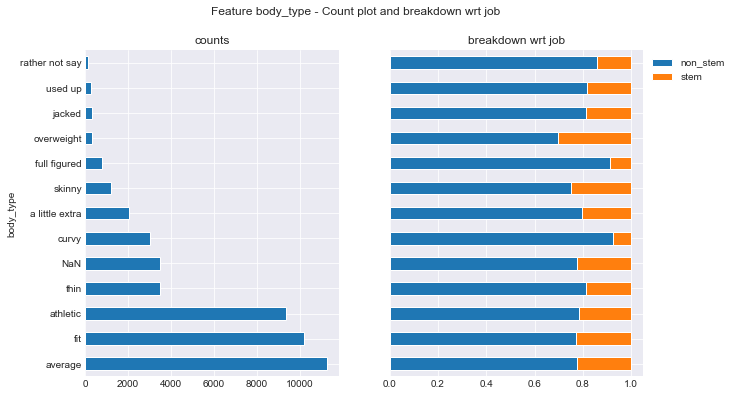

In [421]:
feature = "body_type"
display(Markdown(f"### `{feature}`"))
eda_cat(df,feature,target)

In [422]:
criteria = df[feature].isin(["rather not say","used up"])
df.loc[criteria, feature] = "NaN"

In [423]:
criteria = df[feature] == "a little extra"
df.loc[criteria, feature] = "overweight"

In [424]:
criteria = df[feature]== "jacked" 
df.loc[criteria, feature] = "fit"

In [425]:
criteria = df[feature] == "full figured" 
df.loc[criteria, feature] = "curvy"

In [426]:
df[feature] = pd.Categorical(df[feature].astype(str))

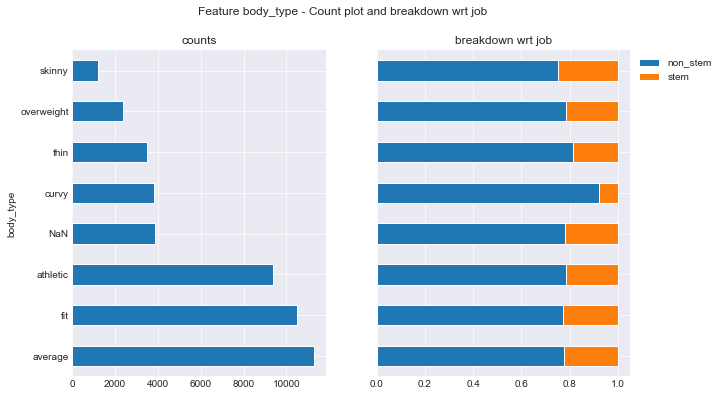

In [427]:
cat_features |= {feature}
eda_cat(df,feature,target)

In [428]:
feature = "diet"

### `diet`

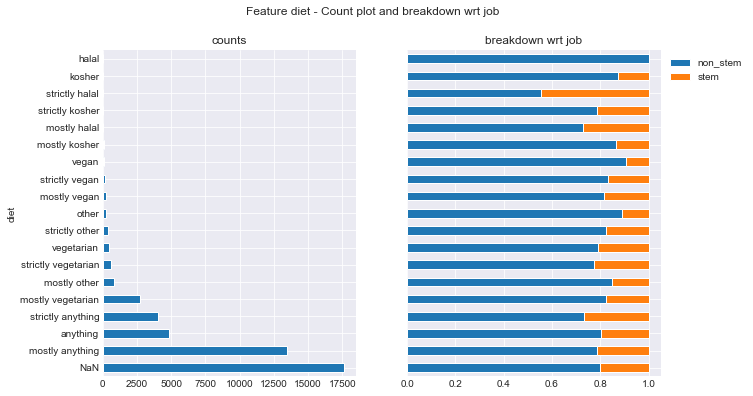

In [429]:
feature = "diet"
display(Markdown(f"### `{feature}`"))
eda_cat(df,feature,target)

In [430]:
df_tmp = df[feature].value_counts()
cut_of = df_tmp["strictly other"] 
to_merge= list(df_tmp[df_tmp < cut_of].index.values)
criteria = df[feature].isin(to_merge)

df.loc[criteria, feature] = "mostly other"

In [431]:
criteria = df[feature] == "strictly vegetarian"
df.loc[criteria, feature] = "vegetarian"

In [432]:
df[feature] = pd.Categorical(df[feature].astype(str))

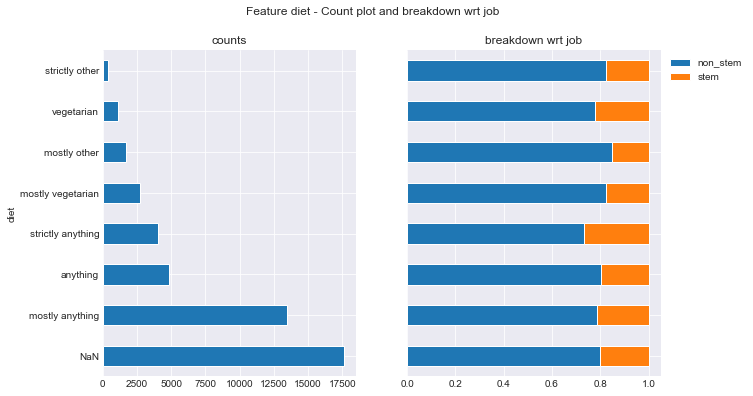

In [433]:
cat_features |= {feature}
eda_cat(df,feature,target)

### `drinks`

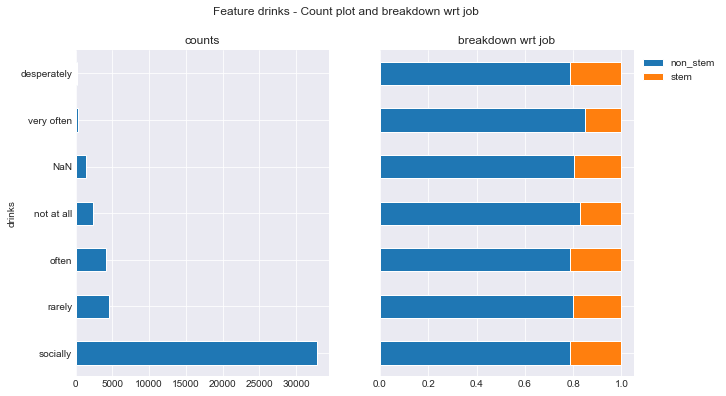

In [434]:
feature = "drinks"
display(Markdown(f"### `{feature}`"))
eda_cat(df,feature,target)

In [435]:
criteria = df[feature].isin(["very often" ,"desperately"])
df.loc[criteria, feature] = "often"

In [436]:
df[feature] = pd.Categorical(df[feature].astype(str))

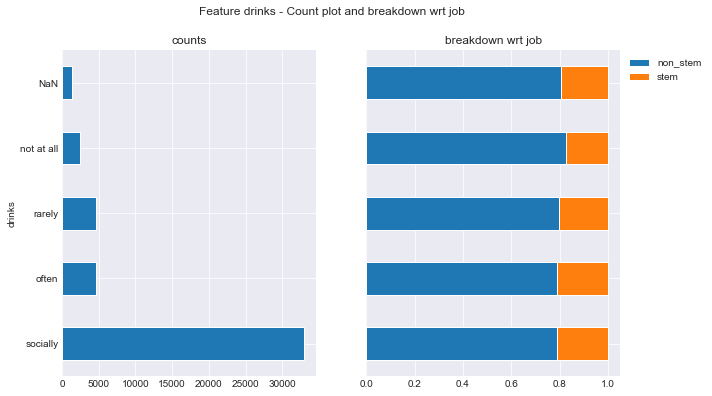

In [437]:
cat_features |= {feature}
eda_cat(df,feature,target)

### `drugs`

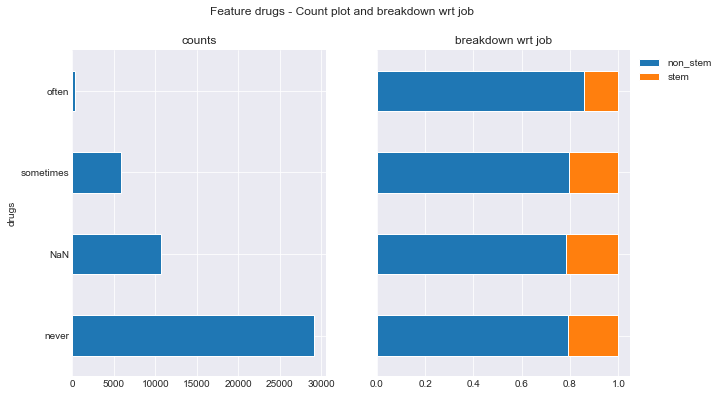

In [438]:
feature = "drugs"
display(Markdown(f"### `{feature}`"))
eda_cat(df,feature,target)

In [439]:
criteria = df[feature] == "often"
df.loc[criteria, feature] ="sometimes"

In [440]:
df[feature] = pd.Categorical(df[feature].astype(str))

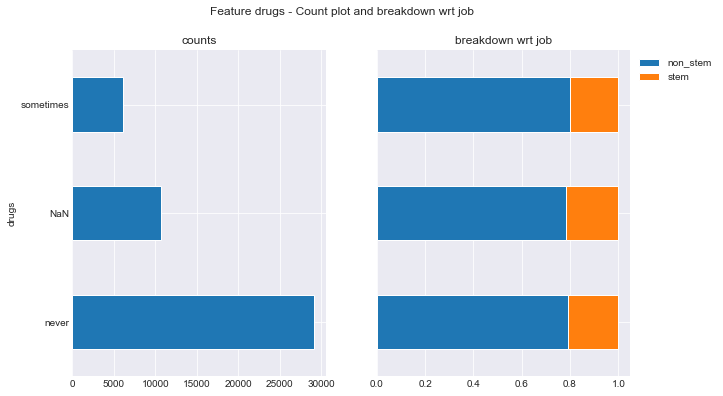

In [441]:
cat_features |= {feature}
eda_cat(df,feature,target)

### `orientation`

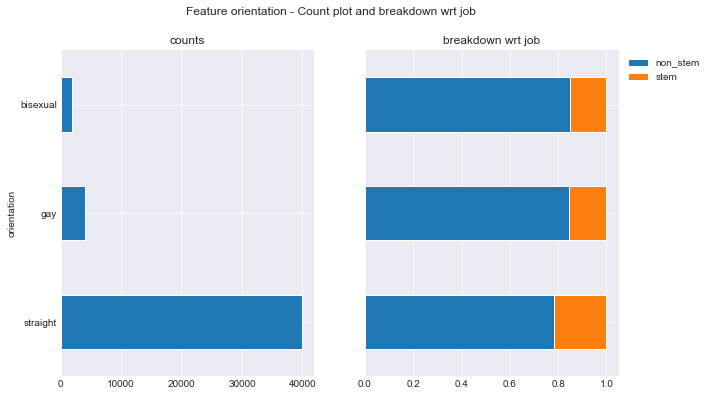

In [442]:
feature = "orientation"
display(Markdown(f"### `{feature}`"))
eda_cat(df,feature,target)

### `pets`

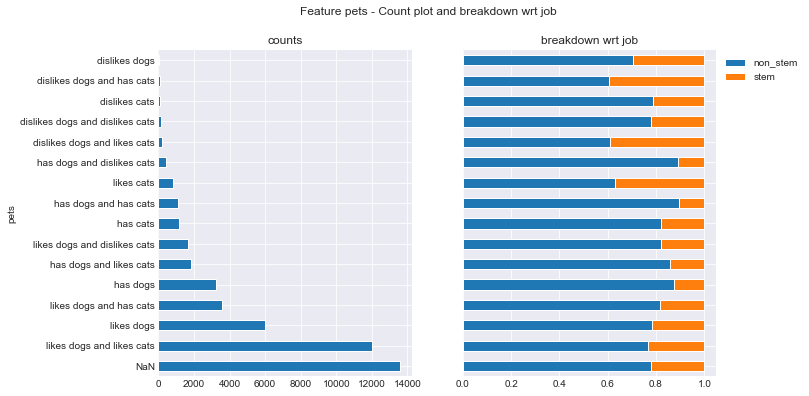

In [449]:
feature = "pets"
display(Markdown(f"### `{feature}`"))
eda_cat(df,feature,target)


    Create four binary features dislikes_dogs, likes_dogs, dislikes_cats, likes_cats by assuming that if someone has a cat/dog they actually like them.


In [465]:
#dislikes_dogs
df[feature].cat.categories


Index(['dislikes cats', 'dislikes dogs', 'dislikes dogs and dislikes cats',
       'dislikes dogs and has cats', 'dislikes dogs and likes cats',
       'has cats', 'has dogs', 'has dogs and dislikes cats',
       'has dogs and has cats', 'has dogs and likes cats', 'likes cats',
       'likes dogs', 'likes dogs and dislikes cats', 'likes dogs and has cats',
       'likes dogs and likes cats', 'NaN'],
      dtype='object')

In [445]:
#likes_dogs

In [ ]:
#dislikes cats

In [447]:
#likes_cats